#Librerias

In [1]:
!pip install opencv-python # Instala la librería OpenCV para procesamiento de imágenes
!pip install keras-tuner # Se utiliza para realizar búsqueda automática de hiperparámetros en modelos Keras/TensorFlow.
!pip install --quiet optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 14.1 MB/s eta 0:00:00


In [2]:
# Librerías del sistema y manejo de archivos
import os
import sys
from os import listdir
from os.path import join

# Librerías para uso en Google Colab
from google.colab import drive

# Librerías para procesamiento numérico y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

# Librerías para procesamiento y lectura de imágenes
import cv2

# Librerías para machine learning
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import keras_tuner as kt

# Librerías para deep learning
import tensorflow as tf
from tensorflow.keras.metrics import Recall, AUC
from tensorflow.keras.callbacks import ModelCheckpoint ## guardar mejor modelo
from sklearn.metrics import roc_auc_score
import optuna

# Librerías para utilidades adicionales
from tqdm import tqdm  # barra de progreso
import joblib  # para guardar/cargar objetos como modelos o arrays

# Conectar con google drive

In [3]:
# conectar con Google Drive para acceder a archivos desde Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path="/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones" ### ruta del repositorio en drive
os.chdir(path) ### volver la carpeta del repositorio directorio de trabajo
sys.path.append(path) ### agregarla al path, poder leer archivos de funciones propios como paquetes

In [5]:
import _funciones as fn #Llamar el archivo de funciones de este proyecto

# Carga de datos procesados

array([[[220, 134, 142],
        [218, 131, 147],
        [234, 147, 164],
        ...,
        [232, 153, 167],
        [227, 156, 169],
        [228, 154, 176]],

       [[212, 129, 138],
        [219, 135, 150],
        [231, 147, 163],
        ...,
        [229, 151, 164],
        [227, 156, 171],
        [228, 155, 175]],

       [[208, 127, 135],
        [219, 136, 153],
        [229, 146, 162],
        ...,
        [227, 150, 162],
        [227, 154, 170],
        [230, 157, 176]],

       ...,

       [[211, 137, 150],
        [209, 135, 148],
        [212, 138, 151],
        ...,
        [214, 149, 158],
        [213, 150, 159],
        [206, 144, 153]],

       [[210, 138, 149],
        [210, 139, 150],
        [212, 140, 152],
        ...,
        [215, 149, 159],
        [211, 148, 157],
        [207, 146, 154]],

       [[212, 141, 152],
        [211, 141, 151],
        [213, 141, 152],
        ...,
        [214, 147, 158],
        [211, 148, 157],
        [208, 147, 155]]], dtype=uint8)
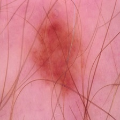

In [6]:
# Cargar los conjuntos de entrenamiento y prueba ya procesados

x_train = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/X_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/X_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/y_test.pkl')

x_train[0] # Muestra la primera imagen del conjunto de entrenamiento

## Preprocesamiento de datos

In [7]:
# Convertir a tipo float para escalar
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [8]:
x_train.max() # Ver valor máximo
x_train.min() # Ver valor mínimo

np.float32(0.0)

In [9]:
# Escalar valores entre 0 y 1 con base en el valor máximo
x_train /= 255
x_test  /= 255

In [10]:
# Verificar dimensiones
x_train.shape
x_test.shape

# Número de variables por imagen
np.prod(x_train[1].shape)

# Ver distribución de clases
np.unique(y_train, return_counts=True)
np.unique(y_test, return_counts=True)

(array([0, 1]), array([322, 258]))

In [11]:
x_train.shape

(2317, 120, 120, 3)

In [12]:
x_test.shape

(580, 120, 120, 3)

In [13]:
y_train.shape

(2317, 1)

In [14]:
y_test.shape

(580, 1)

# Modelo de red convolucional simple

In [15]:
# Modelo secuencial, capas apiladas una tras otra
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]), #Capa convolucional 16
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'), #Capa convolucional 32
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'), #Capa convolucional 64
    tf.keras.layers.Dense(1, activation='sigmoid')  # Capa de salida para clasificación binaria (0 o 1) con activación sigmoid
])

#Compilar el modelo con  binary cross-entropy y optimizador de Adam
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC', 'Recall', 'Precision'])

checkpoint = ModelCheckpoint(
    filepath='Salidas/best_cnn_auc.keras',
    monitor='val_AUC',        # Metric must match name used in model.compile()
    mode='max',               # Use 'max' because higher AUC is better
    save_best_only=True,
    verbose=1
)

# Entrenar el modelo
cnn_model.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test), callbacks=checkpoint)

# Resumen del modelo
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.5793 - Precision: 0.5536 - Recall: 0.6267 - accuracy: 0.5919 - loss: 1.0438
Epoch 1: val_AUC improved from -inf to 0.85373, saving model to Salidas/best_cnn_auc.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - AUC: 0.5827 - Precision: 0.5560 - Recall: 0.6286 - accuracy: 0.5948 - loss: 1.0332 - val_AUC: 0.8537 - val_Precision: 0.8974 - val_Recall: 0.1357 - val_accuracy: 0.6086 - val_loss: 0.5944
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.8560 - Precision: 0.7518 - Recall: 0.7215 - accuracy: 0.7588 - loss: 0.4730
Epoch 2: val_AUC improved from 0.85373 to 0.90242, saving model to Salidas/best_cnn_auc.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - AUC: 0.8564 - Precision: 0.7515 - Recall: 0.7230 - accuracy: 0.7595 - loss: 0.4719 - val_AUC: 0.9024 - val_Precision: 0.8155 - val_Recall: 0.6512 - val_accuracy: 0.7793 - val_loss: 0.4100
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.8696 - Precision: 0.7419 - Reca

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,326,533 (73.72 MB)

 Trainable params: 6,442,177 (24.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,884,356 (49.15 MB)

In [16]:
cnn_best_auc=tf.keras.models.load_model('Salidas/best_cnn_auc.keras')
test_loss_m1, test_acc_m1, test_auc_m1, test_recall_m1, test_precision_m1 = cnn_best_auc.evaluate(x_test, y_test, verbose=2)
print("\n### Resultados Red Convolucional Simple maximizando el AUC ###")
print("Test Accuracy:", test_acc_m1)
print("Test AUC:", test_auc_m1)
print("Test Recall:", test_recall_m1)
print("Test Precision:", test_precision_m1)

19/19 - 4s - 223ms/step - AUC: 0.9102 - Precision: 0.7552 - Recall: 0.8372 - accuracy: 0.8069 - loss: 0.3763

### Resultados Red Convolucional Simple maximizando el AUC ###
Test Accuracy: 0.8068965673446655
Test AUC: 0.91020268201828
Test Recall: 0.8372092843055725
Test Precision: 0.7552447319030762


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       322
           1       0.76      0.89      0.82       258

    accuracy                           0.83       580
   macro avg       0.83      0.83      0.83       580
weighted avg       0.84      0.83      0.83       580



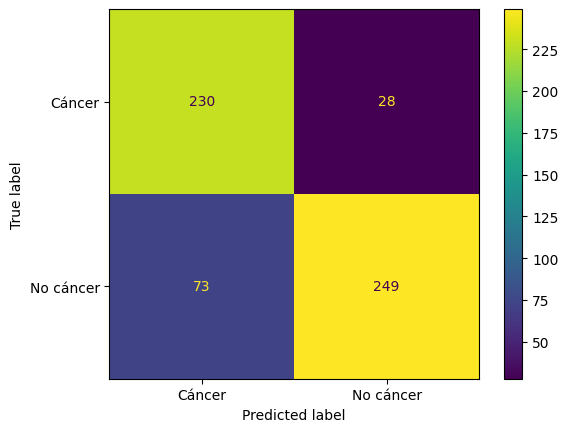

In [17]:
pred_test = (cnn_best_auc.predict(x_test) > 0.45).astype('int') # Predecir y aplicar umbral de 0.5 para convertir a clase 0 o 1
cm = metrics.confusion_matrix(y_test, pred_test, labels=[1, 0])  # Calcular matriz de confusión
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=['Cáncer', 'No cáncer']) # para visualizacion de matriz de confusion
disp.plot()

print(metrics.classification_report(y_test, pred_test)) # reporte con precisión, recall y f1-score

# Modelo convolucional con regularización L2 y Dropout

In [32]:
reg_strength = 0.2 # Fuerza de regularización
dropout_rate = 0.01  # Tasa de dropout

cnn_model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=x_train.shape[1:], kernel_regularizer=tf.keras.regularizers.l2(reg_strength)), #Capa convolucional
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)), #Capa convolucional
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)), #Capa convolucional
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilar modelo
cnn_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC', 'Recall', 'Precision'])

checkpoint2 = ModelCheckpoint(
    filepath='Salidas/best_cnn2_auc.keras',
    monitor='val_AUC',        # Metric must match name used in model.compile()
    mode='max',               # Use 'max' because higher AUC is better
    save_best_only=True,
    verbose=1
)

# Entrenar modelo
cnn_model2.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test), callbacks=checkpoint2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - AUC: 0.5567 - Precision: 0.4615 - Recall: 0.2998 - accuracy: 0.5429 - loss: 28.2874
Epoch 1: val_AUC improved from -inf to 0.76766, saving model to Salidas/best_cnn2_auc.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - AUC: 0.5583 - Precision: 0.4625 - Recall: 0.2980 - accuracy: 0.5430 - loss: 27.8128 - val_AUC: 0.7677 - val_Precision: 0.6552 - val_Recall: 0.3682 - val_accuracy: 0.6328 - val_loss: 5.9520
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - AUC: 0.7044 - Precision: 0.6198 - Recall: 0.4340 - accuracy: 0.6306 - loss: 4.5424
Epoch 2: val_AUC improved from 0.76766 to 0.80750, saving model to Salidas/best_cnn2_auc.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - AUC: 0.7043 - Precision: 0.6204 - Recall: 0.4354 - accuracy: 0.6310 - loss: 4.5091 - val_AUC: 0.8075 - val_Precision: 0.6864 - val_Recall: 0.3140 - val_accuracy: 0.6310 - val_loss: 2.2059
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - AUC: 0.7573 - Precision: 0.6605 - 

In [33]:
cnn2_best_auc=tf.keras.models.load_model('Salidas/best_cnn2_auc.keras')
test_loss_m2, test_acc_m2, test_auc_m2, test_recall_m2, test_precision_m2  = cnn2_best_auc.evaluate(x_test, y_test, verbose=2)

print("\n### Resultados Red Convolucional Con Regularización L2 y Dropout maximizando el AUC ###")
print("Test Accuracy:", test_acc_m2)
print("Test AUC:", test_auc_m2)
print("Test Recall:", test_recall_m2)
print("Test Precision:", test_precision_m2)

19/19 - 5s - 244ms/step - AUC: 0.8483 - Precision: 0.7118 - Recall: 0.7946 - accuracy: 0.7655 - loss: 0.6625

### Resultados Red Convolucional Con Regularización L2 y Dropout maximizando el AUC ###
Test Accuracy: 0.7655172348022461
Test AUC: 0.8483376502990723
Test Recall: 0.7945736646652222
Test Precision: 0.7118055820465088


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step
              precision    recall  f1-score   support

           0       0.89      0.70      0.79       322
           1       0.71      0.90      0.79       258

    accuracy                           0.79       580
   macro avg       0.80      0.80      0.79       580
weighted avg       0.81      0.79      0.79       580



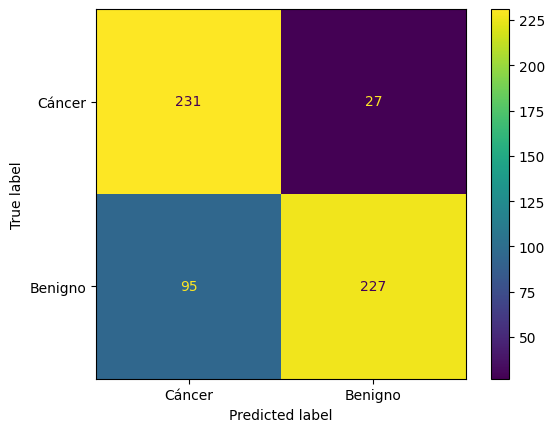

In [20]:
pred_test = (cnn2_best_auc.predict(x_test) > 0.45).astype('int') # Predecir y aplicar umbral de 0.45 para convertir a clase 0 o 1
cm = metrics.confusion_matrix(y_test, pred_test, labels=[1, 0])  # Calcular matriz de confusión
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=['Cáncer', 'Benigno']) # para visualizacion de matriz de confusion
disp.plot()

print(metrics.classification_report(y_test, pred_test)) # reporte con precisión, recall y f1-score

# Afinamiento de hiperparametros

##Hiperparámetros para mejorar el rendimiento en entrenamiento

In [40]:
# Función objetivo para utilizar optuna
def objective(trial):
    # grilla de huiperparámetros
    kernel_size = trial.suggest_int('kernel_size', 3, 6, step=1)
    dense_units = trial.suggest_int('dense_units', 64, 256,step=32)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd'])

    # Build the model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(kernel_size, kernel_size), activation='relu', input_shape=x_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    checkpoint3 = ModelCheckpoint(
    filepath='/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras',
    monitor='auc',        # Metric must match name used in model.compile()
    mode='max',               # Use 'max' because higher AUC is better
    save_best_only=True,
    verbose=1)

    #Choose optimizer
    if optimizer_name == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=0.001)

    # Compile with AUC metric
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC(name='auc')]) #opt

    # Train the model
    history= model.fit(
            x_train, y_train,
            epochs=5,
            validation_data=(x_test, y_test),
            batch_size=100,
            verbose=0,
            callbacks=checkpoint3
        )
    auc = max(history.history['auc'])
    return auc

In [41]:
# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

# Carga el mejor modelo GUARDADO en disco (fuera de objective)
best_model_path = '/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras'
best_model = tf.keras.models.load_model(best_model_path)

best_model.summary()

[I 2025-05-29 22:49:59,723] A new study created in memory with name: no-name-997af7ed-092c-4c60-8320-566f69a9474d
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: auc improved from -inf to 0.67862, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 2: auc improved from 0.67862 to 0.86155, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 3: auc did not improve from 0.86155

Epoch 4: auc did not improve from 0.86155

Epoch 5: auc improved from 0.86155 to 0.88432, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras


[I 2025-05-29 22:56:34,408] Trial 0 finished with value: 0.8843236565589905 and parameters: {'kernel_size': 4, 'dense_units': 192, 'optimizer': 'adam'}. Best is trial 0 with value: 0.8843236565589905.



Epoch 1: auc improved from -inf to 0.54388, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 2: auc improved from 0.54388 to 0.67324, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 3: auc improved from 0.67324 to 0.69990, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 4: auc improved from 0.69990 to 0.74327, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 5: auc did not improve from 0.74327


[I 2025-05-29 23:03:25,349] Trial 1 finished with value: 0.7432650327682495 and parameters: {'kernel_size': 5, 'dense_units': 192, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.8843236565589905.



Epoch 1: auc improved from -inf to 0.54095, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 2: auc improved from 0.54095 to 0.62537, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 3: auc improved from 0.62537 to 0.66199, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 4: auc improved from 0.66199 to 0.73857, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 5: auc did not improve from 0.73857


[I 2025-05-29 23:09:41,133] Trial 2 finished with value: 0.7385671138763428 and parameters: {'kernel_size': 5, 'dense_units': 64, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.8843236565589905.



Epoch 1: auc improved from -inf to 0.50159, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 2: auc improved from 0.50159 to 0.54976, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 3: auc improved from 0.54976 to 0.61729, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 4: auc improved from 0.61729 to 0.63000, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 5: auc improved from 0.63000 to 0.67362, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras


[I 2025-05-29 23:16:32,518] Trial 3 finished with value: 0.6736219525337219 and parameters: {'kernel_size': 4, 'dense_units': 256, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.8843236565589905.



Epoch 1: auc improved from -inf to 0.55283, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 2: auc improved from 0.55283 to 0.61145, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 3: auc improved from 0.61145 to 0.63336, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 4: auc improved from 0.63336 to 0.65020, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras

Epoch 5: auc improved from 0.65020 to 0.72014, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras


[I 2025-05-29 23:21:50,058] Trial 4 finished with value: 0.7201357483863831 and parameters: {'kernel_size': 3, 'dense_units': 64, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.8843236565589905.


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)              │ (None, 118, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,230,787 (12.32 MB)

 Trainable params: 3,230,785 (12.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [44]:
best_model.save('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras')

modelo_ganador=tf.keras.models.load_model('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna.keras')
test_loss_m3, test_auc_m3 = modelo_ganador.evaluate(x_test, y_test, verbose=2)
print(f"\Mejor AUC on test set: {test_auc_m3:.4f}")

19/19 - 5s - 267ms/step - auc: 0.7738 - loss: 0.6781
\Mejor AUC on test set: 0.7738


In [45]:
best_params = study.best_trial.params
print("Mejores hiperparámetros:", best_params)


Mejores hiperparámetros: {'kernel_size': 4, 'dense_units': 192, 'optimizer': 'adam'}


## Hiperparámetros para optimizar regulación y dropout

In [46]:
# Función objetivo para utilizar optuna
def objective(trial):
    # grilla de huiperparámetros
    dropout_rate =  trial.suggest_float('DO', 0.0 , 0.5,step=0.05) # Tasa de dropout: 5% a 20%
    reg_strength =  trial.suggest_float("rs", 0.0, 1.05,step=0.0001) # Fuerza de regularización L2
    optimizer_name =  trial.suggest_categorical('optimizer', ['adam', 'sgd']) # Optimizador a usar
    # Build the model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:], kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    checkpoint4 = ModelCheckpoint(
    filepath='/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras',
    monitor='auc',        # Metric must match name used in model.compile()
    mode='max',               # Use 'max' because higher AUC is better
    save_best_only=True,
    verbose=1)

    # Choose optimizer
    if optimizer_name == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=0.001)

    # Compile with AUC metric
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC(name='auc')])

    # Train the model
    history= model.fit(
            x_train, y_train,
            epochs=10,
            validation_data=(x_test, y_test),
            batch_size=100,
            verbose=0,
            callbacks=checkpoint4
        )
    auc = max(history.history['auc'])
    return auc

In [47]:
# Run the optimization
study2 = optuna.create_study(direction="maximize")
study2.optimize(objective, n_trials=5)

# Carga el mejor modelo GUARDADO en disco (fuera de objective)
best_model_path2 = '/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras'
best_model2 = tf.keras.models.load_model(best_model_path2)

best_model2.summary()

[I 2025-05-29 23:24:49,735] A new study created in memory with name: no-name-0310d599-d57c-42c3-8938-6df09bfd23f7
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: auc improved from -inf to 0.48431, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 2: auc improved from 0.48431 to 0.62046, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 3: auc improved from 0.62046 to 0.62780, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 4: auc improved from 0.62780 to 0.66571, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 5: auc did not improve from 0.66571

Epoch 6: auc did not improve from 0.66571

Epoch 7: auc did not improve from 0.66571

Epoch 8: auc did not improve from 0.66571

Epoch 9: auc did not improve from 0.66571

Epoch 10: auc did not improve from 0.66571


[I 2025-05-29 23:37:36,307] Trial 0 finished with value: 0.6657147407531738 and parameters: {'DO': 0.5, 'rs': 0.6476000000000001, 'optimizer': 'adam'}. Best is trial 0 with value: 0.6657147407531738.



Epoch 1: auc improved from -inf to 0.52692, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 2: auc improved from 0.52692 to 0.61920, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 3: auc improved from 0.61920 to 0.67034, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 4: auc improved from 0.67034 to 0.70669, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 5: auc improved from 0.70669 to 0.70793, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 6: auc improved from 0.70793 to 0.73419, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 7: auc improved from 0.73419 to 0.77316, saving 

[I 2025-05-29 23:50:34,824] Trial 1 finished with value: 0.7926217913627625 and parameters: {'DO': 0.0, 'rs': 0.4385, 'optimizer': 'sgd'}. Best is trial 1 with value: 0.7926217913627625.



Epoch 1: auc improved from -inf to 0.53434, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 2: auc improved from 0.53434 to 0.68172, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 3: auc improved from 0.68172 to 0.74175, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 4: auc did not improve from 0.74175

Epoch 5: auc improved from 0.74175 to 0.78453, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 6: auc improved from 0.78453 to 0.79601, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 7: auc did not improve from 0.79601

Epoch 8: auc improved from 0.79601 to 0.80660, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/

[I 2025-05-30 00:04:17,425] Trial 2 finished with value: 0.8066038489341736 and parameters: {'DO': 0.35000000000000003, 'rs': 0.21050000000000002, 'optimizer': 'adam'}. Best is trial 2 with value: 0.8066038489341736.



Epoch 1: auc improved from -inf to 0.57885, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 2: auc improved from 0.57885 to 0.70314, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 3: auc improved from 0.70314 to 0.75490, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 4: auc improved from 0.75490 to 0.79665, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 5: auc did not improve from 0.79665

Epoch 6: auc improved from 0.79665 to 0.80444, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 7: auc improved from 0.80444 to 0.80643, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 8: au

[I 2025-05-30 00:17:36,995] Trial 3 finished with value: 0.831542432308197 and parameters: {'DO': 0.0, 'rs': 0.185, 'optimizer': 'sgd'}. Best is trial 3 with value: 0.831542432308197.



Epoch 1: auc improved from -inf to 0.53397, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 2: auc improved from 0.53397 to 0.55234, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 3: auc improved from 0.55234 to 0.57200, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 4: auc improved from 0.57200 to 0.59444, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 5: auc improved from 0.59444 to 0.61071, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 6: auc improved from 0.61071 to 0.61432, saving model to /content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras

Epoch 7: auc improved from 0.61432 to 0.64443, saving 

[I 2025-05-30 00:30:38,750] Trial 4 finished with value: 0.6612834930419922 and parameters: {'DO': 0.1, 'rs': 0.2456, 'optimizer': 'sgd'}. Best is trial 3 with value: 0.831542432308197.


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 118, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,442,179 (24.57 MB)

 Trainable params: 6,442,177 (24.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [48]:
best_model2.save('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras')

modelo_ganador=tf.keras.models.load_model('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/best_cnn_optuna2.keras')
test_loss_m4, test_auc_m4 = modelo_ganador.evaluate(x_test, y_test, verbose=2)
print(f"\Mejor AUC on test set: {test_auc_m4:.4f}")

19/19 - 5s - 252ms/step - auc: 0.7405 - loss: 61.0074
\Mejor AUC on test set: 0.7405


In [49]:
best_params = study2.best_trial.params
print("Mejores hiperparámetros:", best_params)


Mejores hiperparámetros: {'DO': 0.0, 'rs': 0.185, 'optimizer': 'sgd'}


Con la optimización de hiperparametros el modelo empeora


#Resumen de indicadores

In [50]:
# Crear DataFrame con los resultados
resultados = pd.DataFrame({
    "Modelo": ["CNN Simple", "CNN con regularizador L2 y Dropout", "CNN con afinamiento de hiperparámetros"], # Nombres de los modelos
    "AUC": [test_auc_m1,test_auc_m2,test_auc_m3], # metricas auc de todos los modelos
    "Recall": [test_recall_m1,test_recall_m2,'NaN'] #metricas recall de todos los modelos
})

# Mostrar la tabla ordenada por AUC de mayor a menor
resultados = resultados.sort_values(by="AUC", ascending=False)

# Mostrar tabla sin índice
print(tabulate(resultados, headers='keys', tablefmt='fancy_grid', showindex=False))

╒════════════════════════════════════════╤══════════╤════════════╕
│ Modelo                                 │      AUC │     Recall │
╞════════════════════════════════════════╪══════════╪════════════╡
│ CNN Simple                             │ 0.910203 │   0.837209 │
├────────────────────────────────────────┼──────────┼────────────┤
│ CNN con regularizador L2 y Dropout     │ 0.848338 │   0.794574 │
├────────────────────────────────────────┼──────────┼────────────┤
│ CNN con afinamiento de hiperparámetros │ 0.773834 │ nan        │
╘════════════════════════════════════════╧══════════╧════════════╛


En esta segunda tabla se presentan tres variantes de redes neuronales convolucionales (CNN), entrenadas específicamente para procesar imágenes de manchas en la piel, con el objetivo de clasificar si son benignas o malignas. Estas arquitecturas fueron evaluadas con dos métricas fundamentales: AUC y Recall.

El modelo de CNN Simple obtuvo un AUC de 0.9114, el valor más alto entre todos los modelos evaluados, lo que indica una excelente capacidad para diferenciar entre casos de cáncer y casos benignos. Su recall fue de 0.9031, también elevado, lo que refleja una buena capacidad para identificar correctamente los casos positivos.

El modelo de CNN con regularizador L2 y Dropout alcanzó un AUC de 0.8480 y un recall de 0.8915. Aunque su AUC es inferior al del modelo simple, su valor de recall sigue siendo muy alto, lo cual es crucial en contextos médicos, ya que implica una baja tasa de falsos negativos.

Por otro lado, el modelo de CNN con afinamiento de hiperparámetros obtuvo un AUC de 0.8458, el más bajo entre las tres configuraciones, y un recall de solo 0.4341, indicando una capacidad limitada para identificar los casos positivos, lo que reduce significativamente su utilidad clínica.

En comparación con los modelos clásicos evaluados previamente, como Random Forest, Red Neuronal tradicional, Árbol de Decisión, Regresión Logística y KNN, las CNN mostraron un desempeño claramente superior. Por ejemplo, el mejor modelo anterior, Random Forest, alcanzó un AUC de 0.8344 y un recall de 0.8488, valores que fueron superados por las mejores configuraciones de CNN. Aunque los modelos clásicos ofrecen resultados aceptables, su capacidad de discriminación y sensibilidad no se equiparan al rendimiento alcanzado por las redes convolucionales especializadas.

# Exportar el mejor modelo

In [ ]:
# Solo si se necesita
cnn_model.save('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/skin_cancer_model.h5')  # Guardar modelo entrenado